In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from random import randint
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.base import clone
from keras.optimizers import Adam
from sklearn.model_selection import KFold   
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

In [3]:
data = pd.read_excel('data_balanced.xlsx')

In [4]:
Data_clean = data

In [5]:
Data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812 entries, 0 to 1811
Data columns (total 12 columns):
Age                    1812 non-null int64
Amount_netCN           1812 non-null float64
TermOfPaymentDays      1812 non-null int64
GDP by State           1812 non-null int64
Unemployment rate      1812 non-null float64
DefaultStatus          1812 non-null int64
month1                 1812 non-null int64
month2                 1812 non-null int64
month3                 1812 non-null int64
month4                 1812 non-null int64
month5                 1812 non-null int64
Feq_default_ZipCode    1812 non-null float64
dtypes: float64(3), int64(9)
memory usage: 170.0 KB


In [6]:
# Print a null value column array
print(Data_clean.columns[Data_clean.isnull().any()])

Index([], dtype='object')


In [7]:
# Create the X and y data sets
X = Data_clean.loc[:, Data_clean.columns != "DefaultStatus"]
y = Data_clean[["DefaultStatus"]]

scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)
# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=.4, random_state=123)

In [8]:
import pickle
filename = 'logistic_model.sav'
# load the model from disk
clf_logistic = pickle.load(open(filename, 'rb'))

In [9]:
# # Train the logistic regression model on the training data
# clf_logistic = LogisticRegression(solver='lbfgs')
# clf_logistic.fit(X_train, np.ravel(y_train))


In [10]:
clf_logistic.predict_proba(X_test)

array([[9.42540242e-01, 5.74597578e-02],
       [1.95221055e-07, 9.99999805e-01],
       [9.99999973e-01, 2.66763793e-08],
       ...,
       [9.99999998e-01, 2.04355507e-09],
       [9.46692978e-01, 5.33070225e-02],
       [3.49768277e-01, 6.50231723e-01]])

In [11]:
# Print the accuracy score the model
print(clf_logistic.score(X_test, y_test))

0.8896551724137931


In [12]:
clf_logistic_roc=roc_auc_score(y_test, clf_logistic.predict(X_test))
clf_logistic_roc

0.8897239100309136

In [13]:
import pickle
filename = 'XGboost_model.sav'
# load the model from disk
clf_gbt = pickle.load(open(filename, 'rb'))

In [14]:
# # Train the Xgboost model on the training data
# clf_gbt = xgb.XGBClassifier()
# clf_gbt.fit(X_train, np.ravel(y_train))

In [15]:
clf_gbt.predict_proba(X_test)

array([[9.9689865e-01, 3.1013433e-03],
       [1.6220629e-02, 9.8377937e-01],
       [9.9890780e-01, 1.0921999e-03],
       ...,
       [9.9983025e-01, 1.6974578e-04],
       [9.9711579e-01, 2.8841894e-03],
       [2.2219390e-01, 7.7780610e-01]], dtype=float32)

In [16]:
# Print the accuracy score the model
print(clf_gbt.score(X_test, y_test))

0.9213793103448276


In [17]:
clf_gbt_roc=roc_auc_score(y_test, clf_gbt.predict(X_test))
clf_gbt_roc

0.9199445688092954

In [18]:
# model_neu = Sequential([
#     Dense(128, activation='relu', input_shape=(18,)),
#     Dense(128, activation='relu'),
#     Dense(1, activation='sigmoid'),
# ])

In [19]:
# model_neu.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [20]:
# model_neu.fit(X_train, np.ravel(y_train),batch_size=32, epochs=100)
#hist = model_neu.fit(X_train, np.ravel(y_train),batch_size=32, epochs=100 )
# remove validation_data=(X_val, Y_val)

In [21]:
#create a dictionary of our models
estimators=[('lr', clf_logistic), ('dt', clf_gbt)  ]   #, ('neu', model_neu)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft')

In [22]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)

0.9117241379310345

In [23]:
# Predict with a model
ensemble_preds = ensemble.predict_proba(X_test)   #gbt_preds is proba

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(ensemble_preds[:,1][:], columns = ['prob_default'])
true_df = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df ], axis = 1))

DefaultStatus  prob_default
0                0      0.030281
1                1      0.991890
2                0      0.000546
3                1      0.721570
4                1      0.732655
..             ...           ...
720              0      0.000260
721              0      0.015947
722              0      0.000085
723              0      0.028096
724              1      0.714019

[725 rows x 2 columns]


In [24]:
ensemble_preds

array([[9.69719447e-01, 3.02805506e-02],
       [8.11041222e-03, 9.91889588e-01],
       [9.99453889e-01, 5.46113306e-04],
       ...,
       [9.99915122e-01, 8.48739105e-05],
       [9.71904384e-01, 2.80956059e-02],
       [2.85981087e-01, 7.14018913e-01]])

In [25]:
# Predict the labels for loan status
ensemble_preds_df = pd.DataFrame(ensemble_preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
ensemble_preds_df['DefaultStatus'] = ensemble_preds_df['prob_default'].apply(lambda x: 1 if x > 0.20 else 0)  # cutoff 0.12

# Check the values created by the predict method
print(ensemble_preds_df['DefaultStatus'].value_counts())

# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(confusion_matrix(y_test,ensemble_preds_df['DefaultStatus']))
print(classification_report(y_test, ensemble_preds_df['DefaultStatus'], target_names=target_names))
print(roc_auc_score(y_test, ensemble_preds_df['DefaultStatus']))

1    433
0    292
Name: DefaultStatus, dtype: int64
[[292  62]
 [  0 371]]
              precision    recall  f1-score   support

 Non-Default       1.00      0.82      0.90       354
     Default       0.86      1.00      0.92       371

    accuracy                           0.91       725
   macro avg       0.93      0.91      0.91       725
weighted avg       0.93      0.91      0.91       725

0.9124293785310734


In [26]:
 ensemble_preds

array([[9.69719447e-01, 3.02805506e-02],
       [8.11041222e-03, 9.91889588e-01],
       [9.99453889e-01, 5.46113306e-04],
       ...,
       [9.99915122e-01, 8.48739105e-05],
       [9.71904384e-01, 2.80956059e-02],
       [2.85981087e-01, 7.14018913e-01]])

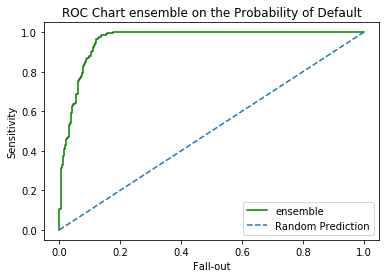

0.9587920873498104


In [27]:
#ensemble_preds = ensemble_preds[:,1] 

# ROC chart components
fallout_ensemble, sensitivity_ensemble, thresholds_ensemble = roc_curve(y_test, ensemble_preds[:,1])

# ROC Chart with both
plt.plot(fallout_ensemble, sensitivity_ensemble, color = 'green', label='%s' % 'ensemble')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart ensemble on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

# Compute the AUC and store it in a variable
print(roc_auc_score(y_test, ensemble_preds[:,1]))

In [28]:
# Creates a model given an activation and learning rate
def create_model(learning_rate=0.01, activation='relu'):
	# Create an Adam optimizer with the given learning rate
	opt = Adam(lr=learning_rate)
	# Create your binary classification model
	model = Sequential()
	model.add(Dense(32, input_shape=(11,), activation=activation))
	model.add(BatchNormalization())
	model.add(Dense(32, activation=activation))
	model.add(BatchNormalization())
	model.add(Dense(1, activation='sigmoid'))
	# Compile your model with your optimizer, loss, and metrics
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [36]:
import pickle
filename = 'neural_model.sav'
# load the model from disk
neural_model = pickle.load(open(filename, 'rb'))

In [37]:
neural_model.get_params()

{'learning_rate': 0.1,
 'epochs': 50,
 'batch_size': 32,
 'activation': 'relu',
 'build_fn': <function __main__.create_model(learning_rate=0.01, activation='relu')>}

In [38]:
neural_model_roc=roc_auc_score(y_test, neural_model.predict(X_test))
neural_model_roc

0.9196209663910336

In [39]:
#create a dictionary of our models
estimators=[('lr', clf_logistic), ('dt', clf_gbt)   , ('neu', neural_model)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft',  weights= [clf_logistic_roc, clf_gbt_roc, neural_model_roc])

In [40]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)

Epoch 1/50
1087/1087 [==============================] - 1s 538us/step - loss: 0.3437 - accuracy: 0.8491
Epoch 2/50
1087/1087 [==============================] - 0s 62us/step - loss: 0.2824 - accuracy: 0.8868
Epoch 3/50
1087/1087 [==============================] - 0s 63us/step - loss: 0.2424 - accuracy: 0.9098
Epoch 4/50
1087/1087 [==============================] - 0s 72us/step - loss: 0.2347 - accuracy: 0.9062
Epoch 5/50
1087/1087 [==============================] - 0s 58us/step - loss: 0.2353 - accuracy: 0.9025
Epoch 6/50
1087/1087 [==============================] - 0s 71us/step - loss: 0.2530 - accuracy: 0.9062
Epoch 7/50
1087/1087 [==============================] - 0s 63us/step - loss: 0.2380 - accuracy: 0.8942
Epoch 8/50
1087/1087 [==============================] - 0s 73us/step - loss: 0.2248 - accuracy: 0.9016
Epoch 9/50
1087/1087 [==============================] - 0s 65us/step - loss: 0.2291 - accuracy: 0.9043
Epoch 10/50
1087/1087 [==============================] - 0s 53us/step - 

0.9227586206896552

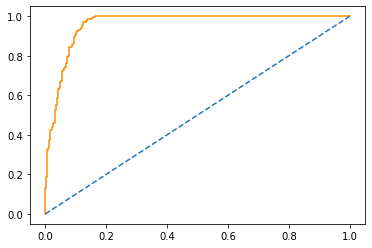

0.9598733001355323


In [41]:
# Plot the ROC curve of the probabilities of default
prob_default_model = ensemble.predict_proba(X_test)[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default_model)  #prob_default is prob
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default_model)
print(auc)